In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

1.15.2


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gzw
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz


--2020-11-05 16:04:07--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gzw
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.170
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.170|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-11-05 16:04:07 ERROR 404: Not Found.

--2020-11-05 16:04:07--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.170
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29515 (29K) [binary/octet-stream]
Saving to: ‘train-lab

In [5]:
!mkdir MNIST_Fashion
! cp *.gz MNIST_Fashion/
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_Fashion/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
mnist.train.images.size

43120000

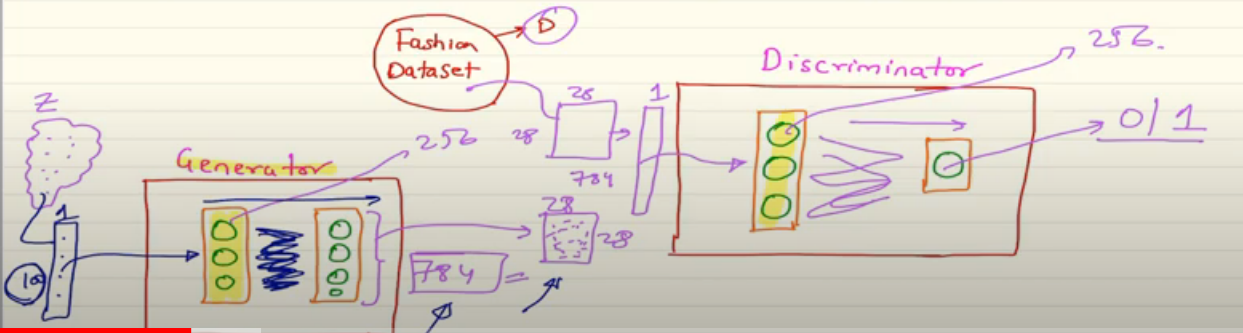

In [ ]:
from IPython.display import Image, display
display(Image('gan1.png'))

In [8]:
#Traning Parametes

learning_rate = 0.0002
batch_size = 128
epochs = 100000

#Network Paramter

img_dim = 784 #Input size 28x28
gan_hidden_dim = 256
disc_hidden_dim = 256
z_noise_dim = 100 #noise data points

In [9]:
def xavier_init(shape):
  return tf.random_normal(shape = shape,stddev = 1./tf.sqrt(shape[0]/2.0))

In [10]:
#Define weights and bias dictionaries

weights = { "disc_H": tf.Variable(xavier_init([img_dim,disc_hidden_dim])),
            "disc_final": tf.Variable(xavier_init([disc_hidden_dim,1])),
            "gan_H": tf.Variable(xavier_init([z_noise_dim,gan_hidden_dim])),
            "gan_final": tf.Variable(xavier_init([gan_hidden_dim,img_dim])) 
}
bias = { "disc_H": tf.Variable(xavier_init([disc_hidden_dim])),
          "disc_final": tf.Variable(xavier_init([1])),
          "gan_H": tf.Variable(xavier_init([gan_hidden_dim])),
          "gan_final": tf.Variable(xavier_init([img_dim]))
    
}

In [11]:
#Create Computational Graph
#Define Discriminator function

def Discriminator(X):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(X,weights['disc_H']),bias['disc_H']))
  final_layer = tf.add(tf.matmul(hidden_layer,weights['disc_final']),bias['disc_final'])
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer,disc_output

#Define generator function
def Generator(X):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(X,weights['gan_H']),bias['gan_H']))
  final_layer = tf.add(tf.matmul(hidden_layer,weights['gan_final']),bias['gan_final'])
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output

#Define the placeholder for exteneral input
z_input = tf.placeholder(tf.float32,shape = [None,z_noise_dim],name='input_noise')
x_input = tf.placeholder(tf.float32,shape = [None,img_dim],name='real_input')

# Building the Generator network
with tf.name_scope('Generator') as scope:
  output_gen = Generator(z_input) #->G(z)

# Building the Discriminator network
with tf.name_scope('Discriminator') as scope:
  real_output1_Disc, real_output_Disc = Discriminator(x_input) #->D(x)
  fake_output1_Disc, fake_output_Disc = Discriminator(output_gen) #->D(G(x))

In [12]:
#First kind of loss
#0.0001 is for loss to not move to infinity
#in tensorflow loss fun try to reduce but we want to increase loss so we use '-'
#max(D){log(D) + log(1-D(G))}
with tf.name_scope('Discriminator_Loss') as scope:
  Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_Disc + 0.0001) + tf.log(1.0 - fake_output_Disc + 0.0001))

#max(G){log(D(G))}
with tf.name_scope('Generator_Loss') as scope:
  Generator_Loss = -tf.reduce_mean(tf.log(fake_output_Disc + 0.0001))
 
#Tensorflow Summary
Disc_loss_total = tf.summary.scalar('Disc_Total_loss',Discriminator_Loss)
Gen_loss_total = tf.summary.scalar('Gen_Total_loss',Generator_Loss)

In [13]:
#Second type of loss
#real_output1_Disc -> we used this because sigmoid cross Loss func does sigmoid before apping Loss func
with tf.name_scope('Discriminator_Loss')  as scope:
  Disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output1_Disc,labels=tf.ones_like(real_output1_Disc)))
  Disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output1_Disc,labels=tf.zeros_like(fake_output1_Disc)))
  Discriminator_Loss = Disc_real_loss + Disc_fake_loss

#we checking where Discriminator is getting fulled or not by checking loss with one output in gen
with tf.name_scope('Generator_Loss')  as scope:
  Generator_Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output1_Disc,labels=tf.ones_like(fake_output1_Disc)))

#Tensorflow Summary
Disc_loss_real_summary = tf.summary.scalar('Disc_loss_real',Disc_real_loss)
Disc_loss_fake_summary = tf.summary.scalar('Disc_loss_fake',Disc_fake_loss)
Disc_loss_summary = tf.summary.scalar('Disc_Total_loss',Discriminator_Loss)

Disc_loss_total = tf.summary.merge([Disc_loss_real_summary,Disc_loss_fake_summary,Disc_loss_summary])
Gen_loss_total = tf.summary.scalar('Gen_Loss',Generator_Loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
#Define the variables
Generator_var = [weights['gan_H'],weights['gan_final'],bias['gan_H'],bias['gan_final']]
Discriminator_var = [weights['disc_H'],weights['disc_final'],bias['disc_H'],bias['disc_final']]

#Define the optimizer
with tf.name_scope('optimizer_Discriminator') as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Discriminator_Loss,var_list=Discriminator_var)
with tf.name_scope('optimizer_Generator') as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Generator_Loss,var_list=Generator_var)

In [14]:
#Intializer the Variable
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter('./log',sess.graph)

for epoch in range(epochs):
  x_batch,_ = mnist.train.next_batch(batch_size)

  #Generate noise to feed the discriminator
  Z_noise = np.random.uniform(-1.,1.,size=[batch_size,z_noise_dim])
  _,Disc_loss_epoch = sess.run([Discriminator_optimize,Discriminator_Loss],feed_dict={x_input: x_batch,z_input:Z_noise})
  _,Gen_loss_epoch = sess.run([Generator_optimize,Generator_Loss],feed_dict={z_input:Z_noise})

  #Running the Discriminator summary
  summary_Disc_Loss = sess.run(Disc_loss_total,feed_dict={x_input: x_batch,z_input:Z_noise})
  writer.add_summary(summary_Disc_Loss,epoch)

  #Running the Discriminator summary
  summary_Gen_Loss = sess.run(Gen_loss_total,feed_dict={z_input:Z_noise})
  writer.add_summary(summary_Gen_Loss,epoch)

  if epoch % 2000 == 0:
    print("Steps :{0} Generator Loss:{1}, Discriminator Loss: {2}".format(epoch,Gen_loss_epoch,Disc_loss_epoch))

Steps :0 Generator Loss:0.3314513564109802, Discriminator Loss: 2.090864658355713
Steps :2000 Generator Loss:4.548923492431641, Discriminator Loss: 0.056589435786008835
Steps :4000 Generator Loss:3.557589530944824, Discriminator Loss: 0.12761898338794708
Steps :6000 Generator Loss:3.7187325954437256, Discriminator Loss: 0.22039681673049927
Steps :8000 Generator Loss:3.1554274559020996, Discriminator Loss: 0.178090438246727
Steps :10000 Generator Loss:3.251723051071167, Discriminator Loss: 0.33025482296943665
Steps :12000 Generator Loss:3.4713759422302246, Discriminator Loss: 0.26750680804252625
Steps :14000 Generator Loss:3.4545178413391113, Discriminator Loss: 0.3438919484615326
Steps :16000 Generator Loss:3.587203025817871, Discriminator Loss: 0.26913389563560486
Steps :18000 Generator Loss:3.3536415100097656, Discriminator Loss: 0.27946338057518005
Steps :20000 Generator Loss:3.2983646392822266, Discriminator Loss: 0.37695497274398804
Steps :22000 Generator Loss:3.490574359893799, D

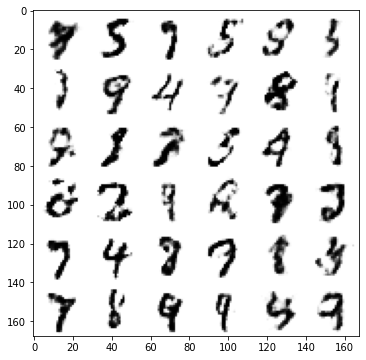

In [16]:
#Testing 
#Generate images from noise, using the generator network
n = 6
canvas = np.empty((28*n,28*n))
for i in range(n):
  #Noise input
  Z_noise = np.random.uniform(-1.,1.,size=[batch_size,z_noise_dim])
  #Generate image from noise.
  g = sess.run(output_gen,feed_dict={z_input:Z_noise})
  #Reverse colours fro better display
  g = -1*(g-1)
  for j in range(n):
    #Drae the generated digits
    canvas[i*28:(i+1)*28,j*28:(j+1)*28] = g[j].reshape([28,28])
  
plt.figure(figsize=(n,n))
plt.imshow(canvas,origin='upper',cmap='gray')
plt.show()